In [5]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
from typing import Dict, List, Tuple
from langchain.chat_models import ChatOpenAI
from langchain_core.output_parsers.string import StrOutputParser
from collections import Counter
from collections import defaultdict

# Analyze SAE Activations

In [6]:

with open("sae_results_filtered.pkl", "rb") as f:
    results = pickle.load(f)

In [162]:
with open("emotional_n_02_thresh.pkl", "rb") as f:
    selected_n = pickle.load(f)

In [77]:
def find_most_active_neurons_for_emotion(top_k, results):
    top_neuron_emotion_pairs = []

    for r in results:
        top_indices = r['activation'].topk(top_k).indices.tolist()
        label = r['label'] 

        for neuron_idx in top_indices:
            top_neuron_emotion_pairs.append((neuron_idx, label))

    return top_neuron_emotion_pairs

def count_frequent_neurons(top_neuron_pairs, k, target_label=None):
    
    if target_label is not None:
        top_neuron_pairs = [n for n, lbl in top_neuron_pairs if lbl == target_label]
    else:
        top_neuron_pairs = [n for n, _ in top_neuron_pairs]

    freqs = Counter(top_neuron_pairs)
    top_common = freqs.most_common(k)
    return top_common




In [78]:
emotions = [[2], [11], [13], [14], [17], [18], [25]]

In [79]:
emotion_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring",
    "confusion", "curiosity", "desire", "disappointment", "disapproval",
    "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
    "joy", "love", "nervousness", "optimism", "pride", "realization",
    "relief", "remorse", "sadness", "surprise", "neutral"
]

In [80]:
pairs = find_most_active_neurons_for_emotion(top_k=50, results=results)
freqs = []
for em in emotions:
    freq = count_frequent_neurons(pairs, k=200, target_label=em)
    freqs.append((freq, em))



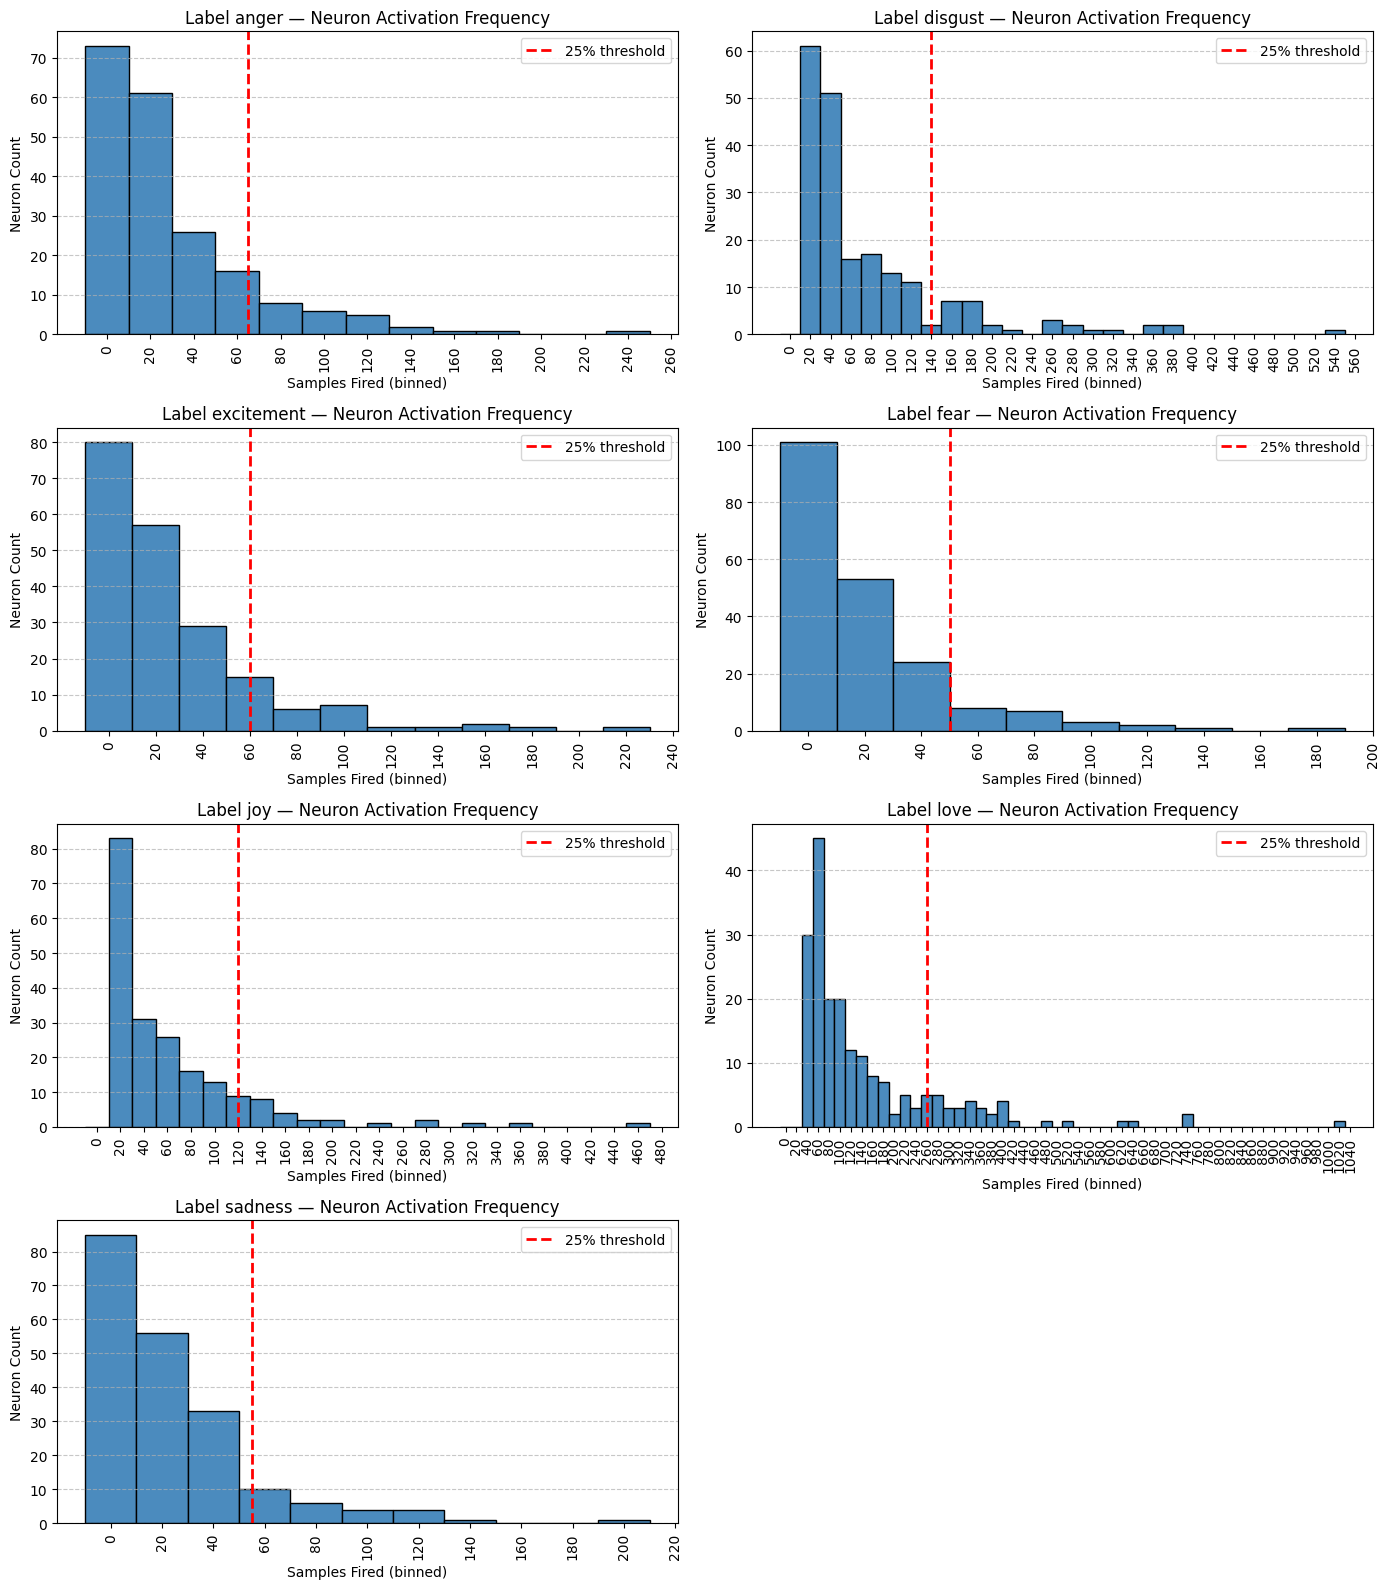

In [81]:
num_emotions = len(freqs)
cols = 2
rows = math.ceil(num_emotions / cols)

fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 4))
axes = axes.flatten()

for i, (freq_list, label) in enumerate(freqs):
    if not freq_list:
        continue

    neuron_freqs = [count for _, count in freq_list]
    bins = np.arange(0, max(neuron_freqs) + 20, 20)

    axes[i].hist(neuron_freqs, bins=bins, edgecolor='black', align='left', color="#4B8BBE")
    axes[i].set_title(f"Label {emotion_labels[label[0]]} — Neuron Activation Frequency", fontsize=12)
    axes[i].set_xlabel("Samples Fired (binned)", fontsize=10)
    axes[i].set_ylabel("Neuron Count", fontsize=10)
    axes[i].set_xticks(bins)
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    x_line = 0.25 * max(bins)
    axes[i].axvline(x=x_line, color='red', linestyle='--', linewidth=2, label='25% threshold')
    axes[i].legend()

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [82]:
freqs_n = []
freq = count_frequent_neurons(pairs, k=200, target_label=[27])
freqs_n.append((freq, [27]))

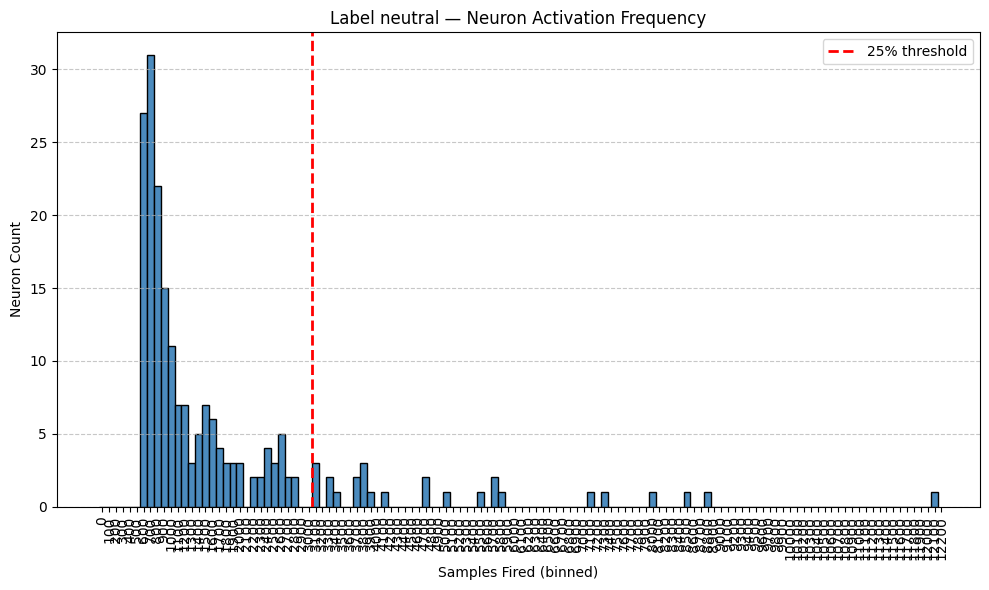

In [54]:
(freq_l, label) = freqs_n[0]
neuron_freqs = [count for _, count in freq_l]
bins = np.arange(0, max(neuron_freqs) + 100, 100)

fig, axes = plt.subplots(figsize=(10, 6))
axes.hist(neuron_freqs, bins=bins, edgecolor='black', align='left', color="#4B8BBE")
axes.set_title(f"Label {emotion_labels[label[0]]} — Neuron Activation Frequency", fontsize=12)
axes.set_xlabel("Samples Fired (binned)", fontsize=10)
axes.set_ylabel("Neuron Count", fontsize=10)
axes.set_xticks(bins)
axes.tick_params(axis='x', rotation=90)
axes.grid(axis='y', linestyle='--', alpha=0.7)

x_line = 0.25 * max(bins)
axes.axvline(x=x_line, color='red', linestyle='--', linewidth=2, label='25% threshold')
axes.legend()

plt.tight_layout()
plt.show()


In [58]:
neutral_neurons = [
    neuron_idx for neuron_idx, count in freq_l
    if count >= x_line
]

print(f"Number of neurons above 25% threshold: {len(neutral_neurons)}")
print("Neuron IDs:", neutral_neurons)

Number of neurons above 25% threshold: 26
Neuron IDs: [9768, 6631, 11099, 2238, 8366, 1858, 1692, 2229, 7077, 9609, 6385, 552, 13611, 7504, 4456, 12184, 14041, 15848, 15509, 5427, 5890, 10758, 2438, 15659, 6107, 2006]


In [83]:
label_to_n_samples = {}

for (neuron_counts, label) in freqs:
    label = label[0]
    label_to_n_samples[label] = max(count for _, count in neuron_counts)


In [84]:
chosen_neurons_by_emotion = {}

for freq_list, label in freqs:
    label = label[0] if isinstance(label, list) else label  
    total_samples = label_to_n_samples[label]
    threshold = 0.25 * total_samples

    chosen_neurons = [
        neuron_idx for neuron_idx, count in freq_list
        if count >= threshold
    ]

    chosen_neurons_by_emotion[label] = chosen_neurons

In [85]:
from scipy.stats import pointbiserialr
import numpy as np

all_chosen_neurons = sorted(set(
    n for neuron_list in chosen_neurons_by_emotion.values() for n in neuron_list
))

# Результат: {label: [(neuron_idx, pbc)]}
pbc_scores_by_emotion = {}

for label in chosen_neurons_by_emotion:
    emotion_scores = []

    for neuron_idx in all_chosen_neurons:

        y = [r["activation"][neuron_idx].item() for r in results]
        
        x = [1 if r["label"] == [label] else 0 for r in results]

        if sum(x) < 10 or sum(x) == len(x):
            continue

        corr, _ = pointbiserialr(x, y)
        if not np.isnan(corr):
            emotion_scores.append((neuron_idx, corr))

    pbc_scores_by_emotion[label] = sorted(emotion_scores, key=lambda x: abs(x[1]), reverse=True)


In [86]:
go_emotion_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring",
    "confusion", "curiosity", "desire", "disappointment", "disapproval",
    "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief",
    "joy", "love", "nervousness", "optimism", "pride", "realization",
    "relief", "remorse", "sadness", "surprise", "neutral"
]

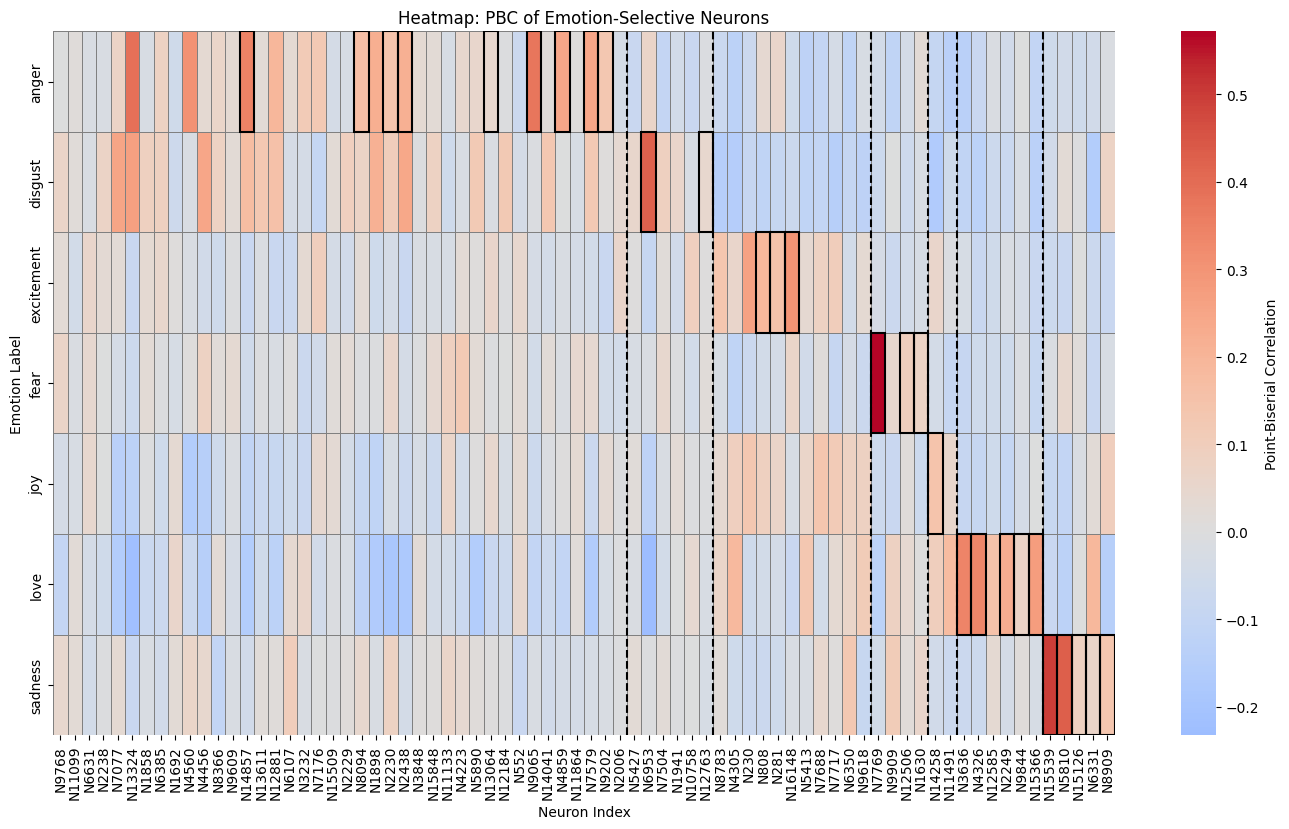

In [87]:
import seaborn as sns

emotion_labels = sorted(chosen_neurons_by_emotion.keys())

neuron_groups = []
split_indices = []
all_neurons = []
used = set()

for label in emotion_labels:
    group = []
    for n in chosen_neurons_by_emotion[label]:
        if n not in used:
            group.append(n)
            all_neurons.append(n)
            used.add(n)
    neuron_groups.append(group)
    split_indices.append(len(all_neurons))

neuron_counts = Counter(n for group in chosen_neurons_by_emotion.values() for n in group)
shared_neurons = {n for n, c in neuron_counts.items() if c > 1}
unique_indices = [i for i, n in enumerate(all_neurons) if n not in shared_neurons]
heatmap_data = np.full((len(emotion_labels), len(all_neurons)), np.nan)
label_to_idx = {label: i for i, label in enumerate(emotion_labels)}
neuron_to_idx = {neuron: i for i, neuron in enumerate(all_neurons)}

for label, scores in pbc_scores_by_emotion.items():
    for neuron, score in scores:
        if neuron in neuron_to_idx:
            row = label_to_idx[label]
            col = neuron_to_idx[neuron]
            heatmap_data[row, col] = score

plt.figure(figsize=(14, max(3, len(emotion_labels) * 1.2)))
ax = sns.heatmap(
    heatmap_data,
    cmap="coolwarm",
    xticklabels=[f"N{n}" for n in all_neurons],
    yticklabels=[f"{go_emotion_labels[l]}" for l in emotion_labels],
    cbar_kws={'label': 'Point-Biserial Correlation'},
    center=0,
    linewidths=0.5,
    linecolor='gray'
)

for x in split_indices[:-1]:
    ax.axvline(x=x, color='black', linestyle='--', linewidth=1.5)

for col in unique_indices:
    neuron = all_neurons[col]
    for row, label in enumerate(emotion_labels):
        if neuron in chosen_neurons_by_emotion[label]:
            ax.add_patch(plt.Rectangle(
                (col, row),   
                1, 1,           
                fill=False,
                facecolor='none',
                edgecolor='black',
                lw=1.5,
                zorder=3
            ))


plt.title("Heatmap: PBC of Emotion-Selective Neurons")
plt.xlabel("Neuron Index")
plt.ylabel("Emotion Label")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [95]:
pbc = {}

for label in emotion_labels:
    pbc[label] = [(neuron, round(float(score), 2)) for neuron, score in pbc_scores_by_emotion[label] if score >= 0.2]



# Visulalization

In [105]:
import pandas as pd

em = [230, 3636, 4560, 4859, 5810, 6953, 7077, 7579, 7769, 9065, 13324, 14857, 15366, 15539]
non_em = [1898, 2249, 2438, 4326, 4456, 16148]

data = []

for label, neuron_scores in pbc.items():
    for neuron_id, score in neuron_scores:
        if neuron_id in em:
            category = 'Emotional'
        elif neuron_id in non_em:
            category = 'Non-Emotional'
        else:
            continue  # Skip neuron_ids not in em or non_em
        data.append({'neuron_id': neuron_id, 'score': score, 'category': category})

df = pd.DataFrame(data)



/var/folders/y4/vhvg_q2n5hz92t1x_6thqyx80000gn/T/ipykernel_30608/2992825188.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




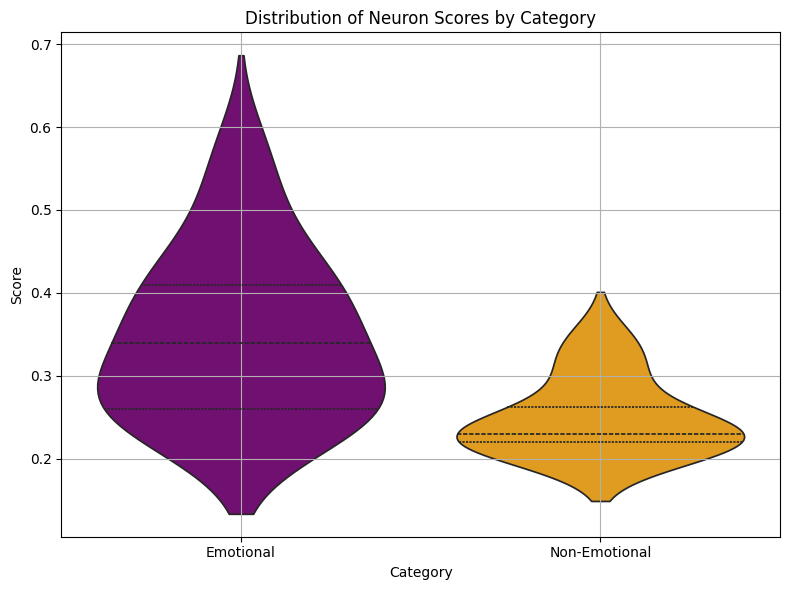

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
custom_palette = {'Emotional': '#800080', 'Non-Emotional': 'orange'} 

plt.figure(figsize=(8, 6))
sns.violinplot(x='category', y='score', data=df, inner='quartile', palette=custom_palette)
plt.title('Distribution of Neuron Scores by Category')
plt.xlabel('Category')
plt.ylabel('Score')
plt.grid(True)
plt.tight_layout()
plt.show()



In [102]:
from scipy.stats import ttest_ind

em_scores = df[df['category'] == 'em']['score']
non_em_scores = df[df['category'] == 'non_em']['score']

t_stat, p_value = ttest_ind(em_scores, non_em_scores, equal_var=False)
print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")


T-statistic: 3.245, P-value: 0.004


# Top K Autointerpretation

In [5]:
with open("emotional_n_02_thresh.pkl", "rb") as f:
    selected_n = pickle.load(f)

In [70]:
emotional_neurons = set(neuron for neurons_list in pbc.values() for neuron in neurons_list)
shared_neurons = emotional_neurons.intersection(neutral_neurons)

print(f"Total emotional neurons: {len(emotional_neurons)}")
print(f"Total neutral neurons: {len(neutral_neurons)}")
print(f"Shared neurons: {len(shared_neurons)}")
print(f"Shared neuron IDs: {sorted(shared_neurons)}")



Total emotional neurons: 20
Total neutral neurons: 26
Shared neurons: 3
Shared neuron IDs: [2438, 4456, 7077]


In [11]:
def get_max_activations(results, emotional_neurons):
    """
    Returns a dict mapping each neuron in emotional_neurons to its max activation value across all samples.
    
    Args:
        results (list of dicts): Each entry should contain "activation" (tensor of shape [num_features])
        emotional_neurons (list of int): Indices of neurons to check

    Returns:
        dict: neuron_idx → max activation value
    """
    max_activations = {n: float('-inf') for n in emotional_neurons}

    for r in results:
        act = r["activation"]
        for n in emotional_neurons:
            val = act[n].item()
            if val > max_activations[n]:
                max_activations[n] = val

    return max_activations


In [12]:
max_act_per_neuron = get_max_activations(results, selected_n)

In [14]:
with open("max_activations_top_k_filt.pkl", "wb") as f:
    pickle.dump(max_act_per_neuron, f)

In [16]:
with open("sae_results_tokens_top_k.pkl", "rb") as f:
    tokens_act = pickle.load(f)

In [17]:
from collections import defaultdict
import heapq

def find_top_activated_tokens_across_samples(results, top_k=5, buffer=3):
    """
    Для каждого нейрона возвращает top-k токенов по активации с контекстом (buffer)
    и активацией рядом с подсвеченным токеном: <<токен>> (score: x.xx)
    """
    SPECIAL_TOKENS = {"<pad>", "<bos>"}
    neuron_to_activations = defaultdict(list)  # neuron → list of (score, tokens, token_idx)

    for r in results:
        tokens = r["tokens"]
        seq_len = len(tokens)

        for token_idx, neuron_idx, value in r["active_neurons"]:
            if token_idx >= seq_len:
                continue
            if tokens[token_idx] in SPECIAL_TOKENS:
                continue
            neuron_to_activations[neuron_idx].append((value, tokens, token_idx))

    neuron_to_samples = {}

    for neuron, act_list in neuron_to_activations.items():
        top_examples = heapq.nlargest(top_k, act_list, key=lambda x: x[0])
        examples_with_scores = []
        
        for act_val, tokens, idx in top_examples:
            seq_len = len(tokens)
            start = max(0, idx - buffer)
            end = min(seq_len, idx + buffer + 1)

            context = tokens[start:end]
            highlight_idx = idx - start

            highlighted = []
            for i, tok in enumerate(context):
                if tok in SPECIAL_TOKENS:
                    continue
                if i == highlight_idx:
                    highlighted.append(f"<<{tok}>>")
                else:
                    highlighted.append(tok)

            text = " ".join(highlighted)
            examples_with_scores.append((act_val, text))

        neuron_to_samples[neuron] = examples_with_scores

    return neuron_to_samples

In [38]:
top_tokens_by_neuron = find_top_activated_tokens_across_samples(tokens_act, top_k=30, buffer=10)

for neuron, toks in list(top_tokens_by_neuron.items())[:6]:
    print(f"Neuron {neuron} fired on tokens: {set(toks)}")


Neuron 9065 fired on tokens: {(63.55299758911133, 'Watching ▁this ▁makes ▁me <<▁angry>> .'), (59.29065704345703, 'Almost ▁downvoted ▁you ▁just ▁because ▁that ▁made ▁me ▁so <<▁angry>> .'), (58.42172622680664, '▁HELP ▁HIM ▁GET ▁OUT ▁REALLY !!! ▁This ▁show ▁makes ▁me <<▁angry>> ▁sometimes .'), (60.88570785522461, "▁are ▁overrated ▁anyways . ▁s . ▁I ' m ▁more <<▁angry>> ▁about ▁back - to - back ▁seasons ▁ending ▁on ▁a"), (65.2951889038086, 'I ▁was ▁a ▁little <<▁pissed>> ▁off ▁until ▁I ▁watched ▁this ▁loop ▁ 6 ▁times .'), (55.70635986328125, 'sorry ▁this ▁happened ▁to ▁you . ▁id ▁be ▁sad <<▁and>> ▁angry ▁too ▁if ▁i ▁worked ▁hard ▁on ▁something , ▁and'), (63.16563034057617, 'sorry ▁this ▁happened ▁to ▁you . ▁id ▁be ▁sad ▁and <<▁angry>> ▁too ▁if ▁i ▁worked ▁hard ▁on ▁something , ▁and ▁someone'), (55.254642486572266, '▁I ▁took ▁up ▁running . ▁It ’ s ▁hard ▁to <<▁stay>> ▁in ▁that ▁state ▁while ▁your ▁legs ▁are ▁burning ▁that ▁much'), (64.21324920654297, "▁Problem ▁is ▁I ▁love ▁those ▁songs ▁so 

In [43]:
def autointerp(
    neuron_data: Dict[int, List[Tuple[float, str]]],
    model_name: str = "gpt-4o-mini",
    top_n: int = 10
) -> Dict[int, str]:
    
    llm = ChatOpenAI(model_name=model_name, temperature=0.3)
    parser = StrOutputParser()
    interpretations = {}

    for neuron_idx, examples in neuron_data.items():
        examples = sorted(examples, key=lambda x: x[0], reverse=True)[:top_n]

        examples_text = "\n".join(
            f"{i+1}. {text} (activation: {score:.2f})"
            for i, (score, text) in enumerate(examples)
        )

        prompt = f"""We're studying neurons in a neural network.
        Each neuron activates on some particular word or concept in a short document.
        Below are {top_n} examples of text fragments that strongly activated **Neuron {neuron_idx}**.
        Each fragment has the token that caused the spike marked with double angle brackets: <<like this>> and activation score in brackets: (activation: ).
        Look at the parts of the document the neuron activates for and summarize in a single sentence what the neuron is activating on.
        Try to be specific in your explanations, although don't be so specific that you exclude some of the examples from matching your explanation.
        Pay attention to things like the capitalization and punctuation of the activating words or concepts, if that seems relevant.
        Keep the explanation as short and simple as possible, limited to 20 words or less.
        Omit punctuation and formatting.
        You should avoid giving long lists of words.
        Answer in the following format: Neuron {neuron_idx} activates on...",

        Examples:
        {examples_text}

        Interpretation:"""
        
        interpretation = parser.invoke(llm.invoke(prompt))
        interpretations[neuron_idx] = interpretation.strip()

    return interpretations


In [44]:
interpretations = autointerp(top_tokens_by_neuron, top_n=30)

for neuron, interp in interpretations.items():
    print(f"Neuron {neuron}: {interp}")


Neuron 9065: Neuron 9065 activates on expressions of anger or frustration.
Neuron 7769: Neuron 7769 activates on expressions of fear or anxiety.
Neuron 15366: Neuron 15366 activates on expressions of affection and endearment towards pets and wholesome moments.
Neuron 13324: Neuron 13324 activates on derogatory terms and insults directed at individuals or groups.
Neuron 7579: Neuron 7579 activates on strong emotional reactions and expressions of frustration or disbelief.
Neuron 7077: Neuron 7077 activates on expressions of strong negative emotions or opinions about people and situations.
Neuron 6953: Neuron 6953 activates on strong negative sentiments and expressions of disgust or disappointment.
Neuron 2438: Neuron 2438 activates on expressions of disagreement or criticism often punctuated by strong emotional language.
Neuron 1898: Neuron 1898 activates on expressions of disbelief frustration or emphasis often using informal language and rhetorical questions
Neuron 4560: Neuron 4560 ac

In [45]:
emotional_lines = [line.strip() for line in interpretations.values() if line.strip()]

for line in emotional_lines:
    print(line)

Neuron 9065 activates on expressions of anger or frustration.
Neuron 7769 activates on expressions of fear or anxiety.
Neuron 15366 activates on expressions of affection and endearment towards pets and wholesome moments.
Neuron 13324 activates on derogatory terms and insults directed at individuals or groups.
Neuron 7579 activates on strong emotional reactions and expressions of frustration or disbelief.
Neuron 7077 activates on expressions of strong negative emotions or opinions about people and situations.
Neuron 6953 activates on strong negative sentiments and expressions of disgust or disappointment.
Neuron 2438 activates on expressions of disagreement or criticism often punctuated by strong emotional language.
Neuron 1898 activates on expressions of disbelief frustration or emphasis often using informal language and rhetorical questions
Neuron 4560 activates on strong emotional expressions and exclamations of frustration or distress.
Neuron 14857 activates on expressions of frustr

In [26]:
def to_df(emotional_lines):
    data = []
    
    for line in emotional_lines:
        parts = line.split("Neuron", 1)
        rest = parts[1].strip()
        idx_str, _, interpretation = rest.partition(" ")
        neuron_idx = int(idx_str)
        data.append({"Neuron Idx": neuron_idx, "Interpretation": interpretation.strip()})

    return pd.DataFrame(data).set_index("Neuron Idx")

In [28]:
import pandas as pd

In [46]:
to_df(emotional_lines).to_csv('top_k_interp_30_examples.csv')

# Fixed VOCAB AUTOINTERP

In [1]:
import json

with open("top_words_per_neuron_drop_stop_30 (1).json", "r") as f:
    tokens_act = json.load(f)


In [2]:
tokens_act

{'2438': [{'word': 'dumbass', 'activation': 38.98729705810547},
  {'word': 'fallacy', 'activation': 38.00019836425781},
  {'word': 'slavery', 'activation': 26.29068374633789},
  {'word': 'said', 'activation': 20.674850463867188},
  {'word': 'daft', 'activation': 20.449649810791016},
  {'word': 'coin', 'activation': 19.842182159423828},
  {'word': 'marriage', 'activation': 19.654266357421875},
  {'word': 'chill', 'activation': 17.46932029724121},
  {'word': 'clue', 'activation': 17.22644805908203},
  {'word': 'petty', 'activation': 16.956253051757812},
  {'word': 'pointing', 'activation': 16.20181655883789},
  {'word': 'degenerate', 'activation': 15.59952163696289},
  {'word': 'filth', 'activation': 15.387430191040039},
  {'word': 'liar', 'activation': 14.889564514160156},
  {'word': 'pathetic', 'activation': 14.595008850097656},
  {'word': 'tbh', 'activation': 13.999490737915039},
  {'word': 'morals', 'activation': 13.790679931640625},
  {'word': 'humanity', 'activation': 13.7526550292

In [3]:
from typing import Dict, List

def autointerp_fixed_vocab(
    neuron_data: Dict[int, List[Dict[str, float]]],  # {neuron_id: [{"word": ..., "activation": ...}, ...]}
    model_name: str = "gpt-4o-mini"
) -> Dict[int, str]:
    
    llm = ChatOpenAI(model_name=model_name, temperature=0.3)
    parser = StrOutputParser()
    interpretations = {}

    for neuron_idx, examples in neuron_data.items():
        # Extract all words
        top_words = [entry['word'] for entry in examples]
        word_str = ", ".join(top_words)

        print(f"Neuron {neuron_idx} activates on words: {word_str}\n")

        prompt = f"""You are studying neurons in a language model.
Each neuron activates on particular concept/topic/theme/behavior/pattern.
Neuron {neuron_idx} activates on the following words: {word_str}.

Guess what this neuron is detecting based on these words.
Do not repeat the list of words. Provide a detailed interpretation using natural language.
Keep the explanation as short and simple as possible, limited to 20 words or less.

If unsure, write: Cannot tell.

Answer in the format:

Neuron {neuron_idx} activates on...
"""

        interpretation = parser.invoke(llm.invoke(prompt))
        interpretations[neuron_idx] = interpretation.strip()

    return interpretations


In [ ]:
interp_fixed_vocab = autointerp_fixed_vocab(tokens_act)

In [119]:
interp_fixed_vocab

{'2438': 'Neuron 2438 activates on themes of criticism, moral judgment, and societal issues related to intelligence and behavior.',
 '15366': 'Neuron 15366 activates on emotional responses related to affection, cuteness, and reactions to heartwarming or infuriating situations.',
 '14857': 'Neuron 14857 activates on casual, informal language related to frustration, relationships, and mental health discussions.',
 '13324': 'Neuron 13324 activates on derogatory language and expressions of frustration or disdain towards people and situations.',
 '16148': 'Neuron 16148 activates on discussions related to political statements or actions involving the presidency and official communications.',
 '7579': 'Neuron 7579 activates on negative emotions, insults, and frustrations related to social interactions and personal experiences.',
 '7077': 'Neuron 7077 activates on casual expressions of frustration, humor, and emotional reactions in everyday conversations.',
 '6953': 'Neuron 6953 activates on n

In [127]:
def verdict_fixed_vocab(
    neuron_data: Dict[int, List[Dict[str, float]]],  # {neuron_id: [{"word": ..., "activation": ...}, ...]}
    summary: Dict[int, str],                         # {neuron_id: "interpreted summary"}
    model_name: str = "gpt-4o-mini"
) -> Dict[int, str]:

    llm = ChatOpenAI(model_name=model_name, temperature=0.3)
    parser = StrOutputParser()
    verdicts = {}

    for neuron_idx in neuron_data:
        examples = neuron_data[neuron_idx]
        interpretation = summary.get(neuron_idx, "N/A")

        # Build word string
        words = [entry['word'] for entry in examples]
        word_str = ", ".join(words)

        # Create evaluation prompt
        prompt = f"""
            You are a linguistic expert. Analyze whether all words toghether from list well represent the concept/topic/theme/pattern.
            Answer depending to whhat extend do you agree: totally correct represent, Morelikely correct, morelikely incorrect, totally incorrect
            Neuron Index: {neuron_idx}
            Interpretation: {interpretation}
            Activated Words: {word_str}

            Respond only in this format:

            Neuron {neuron_idx}: Final Decision:
            """

        verdict = parser.invoke(llm.invoke(prompt))
        verdicts[neuron_idx] = verdict.strip()

    return verdicts



In [128]:
verdicts = verdict_fixed_vocab(tokens_act, interp_fixed_vocab)

In [129]:
verdicts

{'2438': 'Neuron 2438: Final Decision: Morelikely correct',
 '15366': 'Neuron 15366: Final Decision: Morelikely correct',
 '14857': 'Neuron 14857: Final Decision: Morelikely correct',
 '13324': 'Neuron 13324: Final Decision: totally correct represent',
 '16148': 'Neuron 16148: Final Decision: Morelikely correct',
 '7579': 'Neuron 7579: Final Decision: totally correct represent',
 '7077': 'Neuron 7077: Final Decision: Morelikely correct',
 '6953': 'Neuron 6953: Final Decision: totally correct represent',
 '5810': 'Neuron 5810: Final Decision: totally correct represent',
 '15539': 'Neuron 15539: Final Decision: totally correct represent',
 '3636': 'Neuron 3636: Final Decision: Morelikely correct',
 '2249': 'Neuron 2249: Final Decision: totally correct represent',
 '4560': 'Neuron 4560: Final Decision: Morelikely correct',
 '7769': 'Neuron 7769: Final Decision: Morelikely correct',
 '230': 'Neuron 230: Final Decision: Morelikely correct',
 '4326': 'Neuron 4326: Final Decision: Morelikely 

In [125]:
import pandas as pd

df = pd.DataFrame.from_dict(interp_fixed_vocab, orient='index', columns=['summary']).reset_index(names='neuron')


In [126]:
df.to_csv('interp_fixed_vocab_drop.csv')

# Analyze Interpretatios

In [14]:
inp = pd.read_csv('interpretations_final.csv', sep=';', index_col='Neuron Idx')
inp

,Top k interpretation,Emotion,Fixed vocab interp,Emotion.1,Coincides?
Neuron Idx,,,,,
230,activates on expressions of excitement celebra...,excitement,"activates on expressions of surprise, exciteme...",excitement,1
1898,activates on expressions of disbelief frustrat...,anger,activates on emotional reactions and social co...,em_but(mixed),0
2249,activates on expressions of love and affection...,love,"activates on expressions of affection, positiv...",love,1
2438,activates on expressions of disagreement or cr...,anger,"activates on themes of criticism, moral judgme...",anger,1
3636,activates on expressions of personal preferenc...,em_but(preference),"activates on discussions about favorite shows,...",em_but(preference),1
4326,activates on expressions of affection or prefe...,love,"activates on themes of frustration, social dyn...",anger,0
4456,activates on strong negative emotions and reac...,disgust,"activates on negative emotions, frustrations, ...",anger,0
4560,activates on strong emotional expressions and ...,anger,"activates on expressions of frustration, emoti...",anger,1
4859,activates on expressions of frustration anger ...,anger,"activates on expressions of frustration, confu...",anger,1


In [42]:
auto_vs_in = pd.read_csv('auto_int_vs_initial.csv', sep=';', index_col='Neuron Idx')
auto_vs_in

,Emotion Top-k,Emotion Fixed vocan,Initial
Neuron Idx,,,
230,excitement,excitement,excitement
1898,anger,em_but(mixed),"disgust, anger"
2249,love,love,love
2438,anger,anger,"disgust, anger"
3636,em_but(preference),em_but(preference),love
4326,love,anger,love
4456,disgust,anger,disgust
4560,anger,anger,anger
4859,anger,anger,anger


In [68]:
auto_vs_in.columns

Index(['Emotion Top-k', 'Emotion Fixed vocan', 'Initial '], dtype='object')

In [62]:
inp

,Top k interpretation,Emotion,Fixed vocab interp,Emotion.1,Coincides?
Neuron Idx,,,,,
230,activates on expressions of excitement celebra...,excitement,"activates on expressions of surprise, exciteme...",excitement,1
1898,activates on expressions of disbelief frustrat...,anger,activates on emotional reactions and social co...,em_but(mixed),0
2249,activates on expressions of love and affection...,love,"activates on expressions of affection, positiv...",love,1
2438,activates on expressions of disagreement or cr...,anger,"activates on themes of criticism, moral judgme...",anger,1
3636,activates on expressions of personal preferenc...,em_but(preference),"activates on discussions about favorite shows,...",em_but(preference),1
4326,activates on expressions of affection or prefe...,love,"activates on themes of frustration, social dyn...",anger,0
4456,activates on strong negative emotions and reac...,disgust,"activates on negative emotions, frustrations, ...",anger,0
4560,activates on strong emotional expressions and ...,anger,"activates on expressions of frustration, emoti...",anger,1
4859,activates on expressions of frustration anger ...,anger,"activates on expressions of frustration, confu...",anger,1


In [15]:
inp['Emotion'].value_counts()

Emotion
anger                 6
love                  4
excitement            2
disgust               2
disgust, anger        2
em_but(preference)    1
em_but (negative)     1
fear                  1
sadness               1
Name: count, dtype: int64

In [16]:
inp['Emotion.1'].value_counts()

Emotion.1
anger                 7
love                  2
sadness               2
disgust, anger        2
excitement            1
em_but(mixed)         1
em_but(preference)    1
disgust               1
em_but(negative)      1
fear                  1
non-em                1
Name: count, dtype: int64

In [72]:
from collections import defaultdict
import plotly.graph_objects as go

def plot_sankey_from_df(df, column_1, column_2, title):
    # Drop NaNs
    df = df.dropna(subset=[column_1, column_2])
    
    # Create formatted predicted labels
    df['Emotion.2'] = df[column_2].astype(str) + ' '
    
    # Get unique labels
    true_labels = df[column_1].unique().tolist()
    pred_labels = df['Emotion.2'].unique().tolist()
    all_labels = true_labels + pred_labels

    # Mapping each label to a unique index
    label_to_index = {label: i for i, label in enumerate(all_labels)}
    
    # Color palette (extend as needed)
    emotion_to_color = {
        'anger': '#FFA07A',            # Light Salmon
        'disgust': '#8B0000',          # Dark Red
        'fear': '#228B22',             # Forest Green
        'sadness': '#FFFF66',          # Light Yellow
        'excitement': '#DAA520',       # Goldenrod
        'joy': '#FF4500',              # Orange Red
        'love': '#DB7093',             # Pale Violet Red
        'em_but(preference)': '#4169E1',   # Royal Blue
        'em_but(mixed)': '#8A2BE2',        # Blue Violet
        'em_but(negative)': '#FF1493',
        'em_but (negative)': '#FF1493',     # Deep Pink
        'non-em': '#20B2AA',               # Light Sea Green
        'disgust, anger': '#FF6347'        # Tomato
    }


    # Generate node colors
    node_colors = []
    for label in all_labels:
        base_label = label.strip()
        node_colors.append(emotion_to_color.get(base_label, "#CCCCCC"))

    # Count transitions
    counter = defaultdict(int)
    for _, row in df.iterrows():
        src = label_to_index[row[column_1]]
        tgt = label_to_index[row['Emotion.2']]
        counter[(src, tgt)] += 1

    # Build Sankey link data
    link_source, link_target, link_value, link_color = [], [], [], []
    all_values = list(counter.values())
    max_val = max(all_values)

    for (src, tgt), val in counter.items():
        link_source.append(src)
        link_target.append(tgt)
        link_value.append(val)

        norm_alpha = min(1.0, max(0.2, val / max_val))
        hex_color = node_colors[src].lstrip('#')
        r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        link_color.append(f'rgba({r},{g},{b},{norm_alpha:.2f})')

    # Plot Sankey
    fig = go.Figure(go.Sankey(
        arrangement="snap",
        node=dict(
            pad=15,
            thickness=25,
            line=dict(color="black", width=0.5),
            label=all_labels,
            color=node_colors
        ),
        link=dict(
            source=link_source,
            target=link_target,
            value=link_value,
            color=link_color
        )
    ))

    fig.update_layout(
        title_text=f"Emotion Classification Flow ({title})",
        font_size=11,
        margin=dict(l=20, r=20, t=50, b=20),
        width=500,
        height=500
    )

    fig.show()


In [73]:
plot_sankey_from_df(auto_vs_in, 'Initial ','Emotion Top-k', title='Initial -> Top-k')


In [75]:
plot_sankey_from_df(auto_vs_in, 'Initial ','Emotion Fixed vocan', title='Initial -> Fixed Vocabulary')

In [74]:
plot_sankey_from_df(inp, 'Emotion', 'Emotion.1', title='Top-k -> Fixed Vocabulary')

In [71]:
import matplotlib.pyplot as plt

df = df.dropna(subset=['Emotion'])

# Count each unique emotion
emotion_counts = df['Emotion'].value_counts()
emotion_counts['anger'] = 8
emotion_counts['disgust'] = 4
emotion_counts['disgust, anger'] = 0

In [77]:
labels = ['anger', 'disgust, anger', 'disgust', 'fear', 'sadnes', 'excitement', 'love', 'generally emotional']
counts = [6, 2, 2, 1, 1, 2, 4, 2]

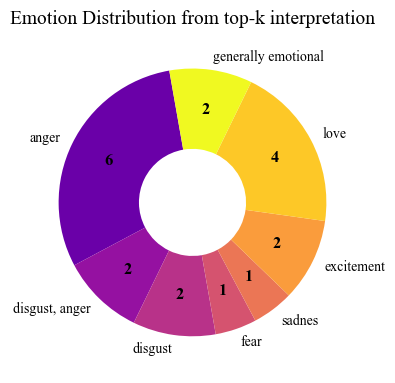

In [95]:
import matplotlib.pyplot as plt

cmap = plt.cm.plasma
colors = cmap(np.linspace(0.2, 1, len(labels)))

# Plot donut chart
plt.figure(figsize=(4, 4))
wedges, texts, autotexts = plt.pie(
    counts,
    labels=labels,
    colors=colors,
    autopct=lambda pct: "",  # no percentage
    startangle=100,
    wedgeprops=dict(width=0.6),
    textprops={'fontsize': 10, 'fontfamily': 'Times New Roman'}
)

# Add absolute counts inside the donut
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = 0.7 * np.cos(np.deg2rad(angle))
    y = 0.7 * np.sin(np.deg2rad(angle))
    plt.text(x, y, str(counts[i]), ha='center', va='center',
             fontsize=12, fontdict={'weight': 'bold', 'family': 'Times New Roman'})

plt.title('Emotion Distribution from top-k interpretation', fontsize=14, fontfamily='Times New Roman')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [105]:
df = df.dropna(subset=['Emotion.1'])

# Count each unique emotion
emotion_counts = df['Emotion.1'].value_counts()
emotion_counts
labels = ['anger', 'disgust, anger', 'disgust', 'fear', 'sadnes', 'excitement', 'love', 'generally emotional', 'non-emotional']
counts = [7, 2, 1, 1, 2, 1, 2, 3, 1]

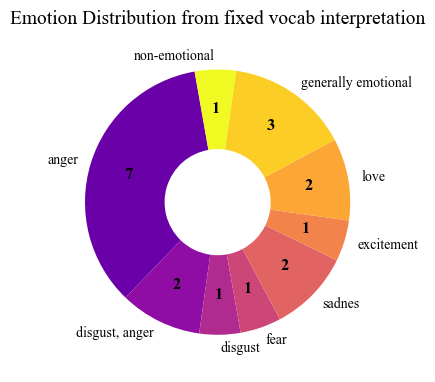

In [107]:
import matplotlib.pyplot as plt

cmap = plt.cm.plasma
colors = cmap(np.linspace(0.2, 1, len(labels)))

# Plot donut chart
plt.figure(figsize=(4, 4))
wedges, texts, autotexts = plt.pie(
    counts,
    labels=labels,
    colors=colors,
    autopct=lambda pct: "",  # no percentage
    startangle=100,
    wedgeprops=dict(width=0.6),
    textprops={'fontsize': 10, 'fontfamily': 'Times New Roman'}
)

# Add absolute counts inside the donut
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = 0.7 * np.cos(np.deg2rad(angle))
    y = 0.7 * np.sin(np.deg2rad(angle))
    plt.text(x, y, str(counts[i]), ha='center', va='center',
             fontsize=12, fontdict={'weight': 'bold', 'family': 'Times New Roman'})

plt.title('Emotion Distribution from fixed vocab interpretation', fontsize=14, fontfamily='Times New Roman')
plt.axis('equal')
plt.tight_layout()
plt.show()